#### This notebook analyses the horizontally-averaged vertical heat budget in the abrupt ACCESS-OM2 experiments.

In [1]:
import cosima_cookbook as cc
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
from scipy.optimize import curve_fit
from xhistogram.xarray import histogram
from dask.distributed import Client
from collections import OrderedDict


%matplotlib inline

In [2]:
client = Client(n_workers=8)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35741/status,
Dashboard: /proxy/35741/status,Workers: 8
Total threads: 8,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40801,Workers: 8
Dashboard: /proxy/35741/status,Total threads: 8
Started: Just now,Total memory: 120.00 GiB
Comm: tcp://127.0.0.1:40187,Total threads: 1
Dashboard: /proxy/39349/status,Memory: 15.00 GiB
Nanny: tcp://127.0.0.1:34667,


In [11]:
### Generate new session

db = '/scratch/e14/mp2135/access-om2/archive/databases/1deg_jra55_ryf_experiments_abrupt_spinup500.db'
session = cc.database.create_session(db)

cc.querying.get_experiments(session)

,experiment,ncfiles
0,1deg_jra55_ryf_cont,15984
1,1deg_jra55_ryf_sinusoid_x1_period2,4626
2,1deg_jra55_ryf_sinusoid_x1_period5,4626
3,1deg_jra55_ryf_sinusoid_x1_period20,4626
4,1deg_jra55_ryf_sinusoid_x1_period10,4626
5,1deg_jra55_ryf_sinusoid_x1_period7,2626
6,1deg_jra55_ryf_sinusoid_x1_period12,2626
7,1deg_jra55_ryf_sinusoid_x1_period16,2626
8,1deg_jra55_ryf_cont_nokb,7906
9,1deg_jra55_ryf_cont_kb4,7906


In [19]:
test = xr.open_mfdataset(paths='/scratch/e14/mp2135/access-om2/archive/1deg_jra55_ryf_cont_heatbudgetdiags/output1*/ocean/ocean_heat.nc', 
                            combine='by_coords')

In [24]:
test.temp_tendency

<xarray.DataArray 'temp_tendency' (time: 12, st_ocean: 50, yt_ocean: 300, xt_ocean: 360)>
dask.array<open_dataset-0e12f45ee19455f95b1180001a43ff8btemp_tendency, shape=(12, 50, 300, 360), dtype=float32, chunksize=(12, 50, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * st_ocean  (st_ocean) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * time      (time) object 2400-01-16 12:00:00 ... 2400-12-16 12:00:00
Attributes:
    long_name:      time tendency for tracer Conservative temperature
    units:          Watts/m^2
    valid_range:    [-1.e+16  1.e+16]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t

In [27]:
test

<xarray.Dataset>
Dimensions:                      (xt_ocean: 360, yt_ocean: 300, st_ocean: 50, st_edges_ocean: 51, time: 12, nv: 2)
Coordinates:
  * xt_ocean                     (xt_ocean) float64 -279.5 -278.5 ... 78.5 79.5
  * yt_ocean                     (yt_ocean) float64 -77.88 -77.63 ... 89.77
  * st_ocean                     (st_ocean) float64 1.152 3.649 ... 5.254e+03
  * st_edges_ocean               (st_edges_ocean) float64 0.0 ... 5.363e+03
  * time                         (time) object 2400-01-16 12:00:00 ... 2400-1...
  * nv                           (nv) float64 1.0 2.0
Data variables: (12/21)
    temp_tendency                (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    temp_advection               (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    temp_submeso                 (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    temp_vdiffuse_diff_cbt       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    temp_vdiffuse_diff_cbt_conv  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    temp_nonlocal_KPP            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    ...                           ...
    mixdownslope_temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    temp_sigma_diff              (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 50, 300, 360), meta=np.ndarray>
    average_T1                   (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_T2                   (time) object dask.array<chunksize=(12,), meta=np.ndarray>
    average_DT                   (time) timedelta64[ns] dask.array<chunksize=(12,), meta=np.ndarray>
    time_bounds                  (time, nv) timedelta64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
Attributes:
    filename:   ocean_heat.nc
    title:      ACCESS-OM2
    grid_type:  mosaic
    grid_tile:  1

In [39]:
def vertical_heat_budget(expt):
    ds = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean_heat.nc', 
                            combine='by_coords')
    area = xr.open_mfdataset(paths=f'/scratch/e14/mp2135/access-om2/archive/{expt}/output1*/ocean/ocean_grid.nc', 
                            combine='by_coords').area_t
    
    # Tendency
    temp_tendency = ds.temp_tendency
    
    # Advection
    adv = ds.temp_advection
    neutral_gm_temp = ds.neutral_gm_temp
    temp_submeso = ds.neutral_gm_temp
    
    # Vertical mixing
    temp_vdiffuse_diff_cbt = ds.temp_vdiffuse_diff_cbt
    temp_nonlocal_KPP = ds.temp_nonlocal_KPP
    mixdownslope_temp = ds.mixdownslope_temp
    temp_sigma_diff = ds.temp_sigma_diff
    
    # Isopycnal mixing
    neutral_diffusion_temp = ds.neutral_diffusion_temp
    temp_vdiffuse_k33 = ds.temp_vdiffuse_k33
    
    # Surface forcing
    sw_heat = ds.sw_heat
    frazil_3d = ds.frazil_3d
    temp_rivermix = ds.temp_rivermix
    temp_vdiffuse_sbc = ds.temp_vdiffuse_sbc
    
    
    def integrate_variable(variable):
        return (variable * area).sum('xt_ocean').sum('yt_ocean').groupby('time.year').mean('time').cumsum('st_ocean')
    
    
    tendency = integrate_variable(temp_tendency).load()
    advection = integrate_variable(adv + neutral_gm_temp + temp_submeso).load()
    vertical_mixing = integrate_variable(temp_vdiffuse_diff_cbt + temp_nonlocal_KPP + mixdownslope_temp + temp_sigma_diff).load()
    isopycnal_mixing = integrate_variable(neutral_diffusion_temp + temp_vdiffuse_k33).load()
    surface_forcing = integrate_variable(sw_heat + frazil_3d + temp_rivermix + temp_vdiffuse_sbc).load()
    
    
    return tendency, advection, vertical_mixing, isopycnal_mixing, surface_forcing

In [40]:
yr_beg = '2400-02-01'
# yr_end = '2409-12-31'

expt = '1deg_jra55_ryf_cont_heatbudgetdiags'
heat_budget_cont = vertical_heat_budget(expt)

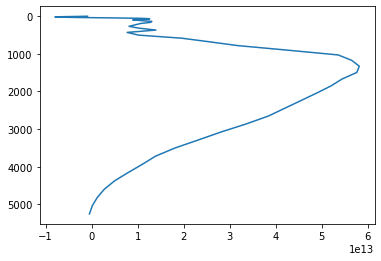

In [70]:
plt.plot(heat_budget_cont[0][0,:],heat_budget_cont[0].st_ocean)
plt.gca().invert_yaxis()

In [74]:
heat_budget_cont[0][0,:].sel(st_ocean=slice(None,depth))

<xarray.DataArray (st_ocean: 28)>
array([-9.1096646e+11, -1.9957868e+12, -3.2781196e+12, -4.8323667e+12,
       -6.6990275e+12, -7.9958114e+12, -7.7166721e+12, -4.8343800e+12,
       -6.0900455e+11,  5.0487424e+12,  1.0897219e+13,  1.2625121e+13,
        1.1122403e+13,  8.9337364e+12,  1.0784898e+13,  1.3080304e+13,
        1.2766347e+13,  1.0643982e+13,  9.4928330e+12,  8.1181221e+12,
        1.0089116e+13,  1.3969717e+13,  7.7034753e+12,  1.0163205e+13,
        1.9543397e+13,  2.5406604e+13,  3.1834008e+13,  4.2356443e+13],
      dtype=float32)
Coordinates:
  * st_ocean  (st_ocean) float64 1.152 3.649 6.565 9.971 ... 677.1 782.1 899.7
    year      int64 2400

In [79]:
z

<xarray.DataArray 'st_ocean' (st_ocean: 28)>
array([  1.15175 ,   3.648674,   6.564919,   9.970869,  13.948709,  18.594379,
        24.019873,  30.355885,  37.75489 ,  46.394703,  56.482571,  68.259865,
        82.007408,  98.051468, 116.770348, 138.601608, 164.049438, 193.692062,
       228.188141, 268.281219, 314.800171, 368.653534, 430.813934, 502.289307,
       584.077087, 677.100281, 782.126709, 899.681763])
Coordinates:
  * st_ocean  (st_ocean) float64 1.152 3.649 6.565 9.971 ... 677.1 782.1 899.7
Attributes:
    long_name:       tcell zstar depth
    units:           meters
    cartesian_axis:  Z
    positive:        down
    edges:           st_edges_ocean

(0.0, 1000.0)

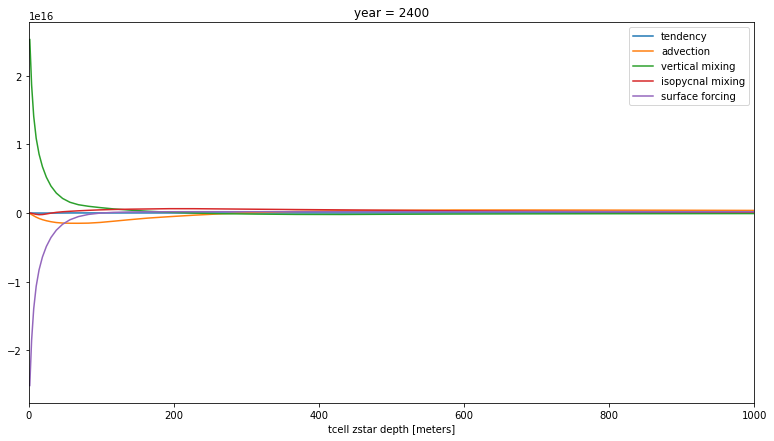

In [82]:
plt.figure(figsize=(13,7))

depth = 1000

heat_budget_cont[0].plot(label='tendency')
heat_budget_cont[1].plot(label='advection')
heat_budget_cont[2].plot(label='vertical mixing')
heat_budget_cont[3].plot(label='isopycnal mixing')
heat_budget_cont[4].plot(label='surface forcing')

plt.legend()
plt.xlim(0,depth)